# Cachelib YCSB Graph Plot Scripts

In [3]:
import re
from pprint import pprint

def parse_line(line):
    # Pattern to extract the initial date, time, duration, and total operations
    main_pattern = re.compile(r'\*\*\*(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) (\d+) sec: (\d+) operations;')
    
    # Pattern to extract each operation and its metrics
    operation_pattern = re.compile(r'\[(\w+-?\w*): Count=(\d+) Max=([\d.]+) Min=([\d.]+) Avg=([\d.]+) 90=([\d.]+) 99=([\d.]+) 99.9=([\d.]+) 99.99=([\d.]+)\]')
    
    # Match the main pattern
    main_match = main_pattern.search(line)
    
    if main_match:
        date_time = main_match.group(1)
        duration = int(main_match.group(2))
        total_operations = int(main_match.group(3))
        
        result = {
            'date_time': date_time,
            'duration_sec': duration,
            'total_operations': total_operations,
            'operations': {}
        }
        
        # Find all operations
        operations_matches = operation_pattern.findall(line)
        
        for op in operations_matches:
            operation_name = op[0]
            metrics = {
                'count': int(op[1]),
                'max': float(op[2]),
                'min': float(op[3]),
                'avg': float(op[4]),
                '90th_percentile': float(op[5]),
                '99th_percentile': float(op[6]),
                '99.9th_percentile': float(op[7]),
                '99.99th_percentile': float(op[8])
            }
            result['operations'][operation_name] = metrics
            
        return result
    else:
        return None

def parse_log_file(file_name):
  throughput = []
  read_avg_lat = []
  read_p99_lat = []
  # get_operation = []
  perf_throughput = []
  cap_throughput = []
  dram_hit_ratio = []
  nvm_hit_ratio = []
  last_timestamp = 0
  last_get = 0
  last_dram_hit = 0
  last_nvm_hit = 0
  with open(file_name, 'r') as f:
    for line in f:
      if line.startswith("Run throughput(ops/sec"):
        tokens = line.split()
        tp = int(float(tokens[-1]))
        throughput.append(tp)
      elif line.startswith("Finished Client"):
        tokens = line.split()
        finished_clinet = int(tokens[-1])
        if finished_clinet > 0:
           break
      elif line.startswith("***"):
        result = parse_line(line)
        #  print(result, line)
        if result is not None and "READ" in result["operations"]:
          read_avg_lat.append(result["operations"]["READ"]["avg"])
          read_p99_lat.append(result["operations"]["READ"]["99th_percentile"])
      elif line.startswith("###"):
        tokens = line.split()
        timestamp = int(tokens[1])
        get = tokens[2]
        dram_hit = tokens[3]
        nvm_hit = tokens[4]
        perf_tp = tokens[5]
        cap_tp = tokens[6]
        # print(tokens)

        if abs(timestamp - last_timestamp) <= 1:
          perf_throughput.append(int(perf_tp))
          cap_throughput.append(int(cap_tp))
          dram_hit_ratio.append(float(dram_hit))
          nvm_hit_ratio.append(float(nvm_hit))
        last_timestamp = timestamp



  return throughput, read_avg_lat, read_p99_lat, perf_throughput, cap_throughput, dram_hit_ratio, nvm_hit_ratio


        

## 1 KB Workload

### Nvme/SATA

optane_nvme workloada Stable at 23:05:02.671221 duration86395 starting at 23:04:48.071668
optane_nvme workloadb Stable at 23:56:44.195714 duration86400 starting at 23:57:37.609132
optane_nvme workloadc Stable at 01:35:56.021256 duration86396 starting at 01:37:11.437444
optane_nvme workloadd Stable at 03:00:03.652512 duration86395 starting at 03:00:16.227814
optane_nvme workloadf Stable at 04:43:54.106739 duration210 starting at 04:43:39.527250
Throughput 0.31281100910548554 [0.35934018 0.50274202 0.40768815 0.15317349 0.1411112 ]
Average Latency -0.17471772052673434 [-0.26015228 -0.2303207  -0.25172414 -0.032      -0.09939148]
P99 Latency -0.20130463700234533 [-0.30695725 -0.18676244 -0.30764873 -0.08317215 -0.12198262]
nvme_sata workloada Stable at 06:15:44.747115 duration86397 starting at 06:15:28.151797
nvme_sata workloadb Stable at 08:33:52.387472 duration266 starting at 08:33:56.388221
nvme_sata workloadc Stable at 11:44:34.343356 duration270 starting at 11:44:30.342778
nvme_sata 

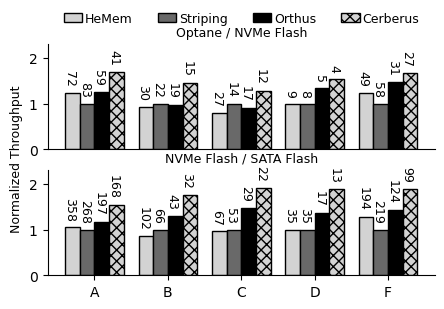

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
result_dir = "result3"
# latency is in microsecond
hierarchy = ["optane_nvme", "nvme_sata"]
# workload = ["workloada", "workloadb", "workloadc", "workloadd", "workloade", "workloadf"]
workload = ["workloada", "workloadb", "workloadc", "workloadd", "workloadf"] 
mode_list = ["tiering", "striping", "caching", "most"]
color_list = [ 'lightgrey', 'dimgray', 'black', 'lightgray']
label_list = ['HeMem', 'Striping', 'Orthus', 'Cerberus']
hatch_list = ['', '', '', 'xxx']

fig, axes = plt.subplots(2, 1, figsize=(5, 3))
def duration_in_seconds(timestamp1: str, timestamp2: str) -> int:
    # Parse the timestamp strings into datetime objects
    time_obj1 = datetime.strptime(timestamp1, '%H:%M:%S.%f')
    time_obj2 = datetime.strptime(timestamp2, '%H:%M:%S.%f')
    
    # Calculate the difference between the two timestamps
    duration = int((time_obj2 - time_obj1).total_seconds())
    
    # Return the total duration in seconds (as an integer)
    return duration if duration > 0 else duration + 86400

def find_true_and_window(arr, x, y):
    # Find the index of the first True
    first_true_idx = next((i for i, val in enumerate(arr) if val), None)
    
    # Find the index of the first element in the x-continuous window
    window_idx = None
    for i in range(len(arr) - x + 1):
        window = arr[i:i + x]
        true_count = sum(window)
        false_count = len(window) - true_count
        
        if false_count <= y:
            window_idx = i
            break
    
    return first_true_idx, window_idx
avg_latency_improvement = []
p99_latency_improvement = []
conv_time = []
for h_idx, h in enumerate(hierarchy):
  result = {}
  cov = []
  for w in workload:
    base_dir = os.path.join(result_dir, h, w)
    for file_name in os.listdir(base_dir):
      # print(file_name)
      if file_name.endswith('.result'):
        tokens = file_name.split('.')[0].split('_')
        mode = tokens[1]
        tp, read_avg, read_p99,_,_,_,_ = parse_log_file(os.path.join(base_dir, file_name))
        if mode not in result:
          result[mode] = {}
          result[mode]["tp"] = []
          result[mode]["avg"] = []
          result[mode]["p99"] = []
        
        # if w == "workloadd":
        #   start_idx = -8
        #   end_idx = -3
        # elif w == "workloadb":
        #   start_idx = -10
        #   end_idx = -4
        # else:
        start_idx = -4
        end_idx = -1
        # print(tp[start_idx:end_idx])

        result[mode]["tp"].append(np.mean(tp[start_idx:end_idx]))
        result[mode]["avg"].append(np.mean(read_avg[int(start_idx/2):end_idx]))
        result[mode]["p99"].append(np.mean(read_p99[int(start_idx/2):end_idx]))
      elif file_name.endswith('.error'):
        tokens = file_name.split('.')[0].split('_')
        mode = tokens[1]
        # print(mode)
        if mode != "most":
          continue
        migration_list = []
        timestamp_list = []
        with open(os.path.join(base_dir, file_name)) as f:
          for line in f:
            # print(line)
            if line.endswith("***\n"):
              tokens = line.split()
              # timestamp = 
              migration_down = True if tokens[-3] == "true" else False
              migration_up = True if tokens[-2] == "true" else False
              # print(migration_down, migration_up)
              migration_list.append(not (migration_down | migration_up ))
              timestamp_list.append(tokens[1])
        # print(migration_list)
        # print(timestamp_list)
        stable_count = 0
        unstable_count = 0
        is_first_true=True
        start_idx = 0
        window_size = 40
        first_true_idx, window_idx = find_true_and_window(migration_list, window_size, 10)

        converage = duration_in_seconds(timestamp_list[first_true_idx], timestamp_list[window_idx])
        print(f"{h} {w} Stable at {timestamp_list[window_size]} duration{converage} starting at {timestamp_list[first_true_idx]}")
        conv_time.append(converage)
     
          



        

  X = np.array(range(len(workload)))
  width= 0.2
  baseline="caching"
  
  for idx, mode in enumerate(mode_list):
    # print(mode, result[mode]["tp"], result[mode]["avg"], result[mode]["p99"])
    tp_improvement = (np.array(result[mode]["tp"]) - result[baseline]["tp"])/ result[baseline]["tp"]
    avg_lat_improvement = (np.array(result[mode]["avg"]) - result[baseline]["avg"])/ result[baseline]["avg"]
    p99_lat_improvement = (np.array(result[mode]["p99"]) - result[baseline]["p99"])/ result[baseline]["p99"]
    # print(mode)
    if mode == "most":
      print("Throughput", np.mean(tp_improvement), tp_improvement) 
      print("Average Latency", np.mean(avg_lat_improvement), avg_lat_improvement) 
      print("P99 Latency", np.mean(p99_lat_improvement), p99_lat_improvement) 
      avg_latency_improvement.append(avg_lat_improvement)
      p99_latency_improvement.append(p99_lat_improvement)
    collection = axes[h_idx].bar(X - 3/2 * width + idx *width, np.array(result[mode]["tp"]) /result["striping"]["tp"], width=width, color=color_list[idx], label=label_list[idx], edgecolor='black', hatch=hatch_list[idx])
    for index, bar in enumerate(collection):
      yval = bar.get_height()
      # print(index, )
      
      axes[h_idx].text(bar.get_x() + bar.get_width() * 0.6 / 2, yval+0.15, int(result[mode]["p99"][index]), ha='center', va='bottom', fontsize=9, rotation=-90)
labels = {
  "workloada": "A",
  "workloadb": "B",
  "workloadc": "C",
  "workloadd": "D",
  "workloade": "E",
  "workloadf": "F"
}
print(np.mean(avg_latency_improvement), np.mean(p99_latency_improvement))
print(conv_time, np.mean(conv_time[:5]))
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].set_title("Optane / NVMe Flash", fontsize=9)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

axes[0].set_ylim(0, 2.3)
axes[1].set_ylim(0, 2.3)


axes[0].set_xticks([])
axes[1].set_xticks(X)
axes[1].set_xticklabels([labels[x] for x in workload])
# axes[1].set_xlabel("YCSB Workload")
axes[1].set_title("NVMe Flash / SATA Flash", fontsize=9)

# axes[0].legend(frameon=False, ncol=2)
axes[0].legend(
    frameon=False, fontsize=9, ncol=4, loc="center", bbox_to_anchor=(0.5, 1.25), labelspacing=0.2, handlelength=1.5, handletextpad=0.2, borderpad=0.2,
)
fig.text(
    0.05,
    0.5,
    "Normalized Throughput",
    va="center",
    rotation="vertical",
    fontsize=9,
)



fig.savefig("ycsb_1k.jpg", dpi=1200, bbox_inches='tight')




In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
result_dir = "test5"
# latency is in microsecond
hierarchy = ["optane_nvme"]
# workload = ["workloada", "workloadb", "workloadc", "workloadd", "workloade", "workloadf"]
workload = ["workloadc"] 
mode_list = ["tiering", "striping", "caching", "most"]
color_list = [ 'lightgrey', 'dimgray', 'black', 'lightgray']
label_list = ['HeMem', 'Striping', 'Orthus', 'Cerberus']
hatch_list = ['', '', '', 'xxx']

# fig, axes = plt.subplots(2, 1, figsize=(5, 3))
def duration_in_seconds(timestamp1: str, timestamp2: str) -> int:
    # Parse the timestamp strings into datetime objects
    time_obj1 = datetime.strptime(timestamp1, '%H:%M:%S.%f')
    time_obj2 = datetime.strptime(timestamp2, '%H:%M:%S.%f')
    
    # Calculate the difference between the two timestamps
    duration = int((time_obj2 - time_obj1).total_seconds())
    
    # Return the total duration in seconds (as an integer)
    return duration if duration > 0 else duration + 86400

def find_true_and_window(arr, x, y):
    # Find the index of the first True
    first_true_idx = next((i for i, val in enumerate(arr) if val), None)
    
    # Find the index of the first element in the x-continuous window
    window_idx = None
    for i in range(len(arr) - x + 1):
        window = arr[i:i + x]
        true_count = sum(window)
        false_count = len(window) - true_count
        
        if false_count <= y:
            window_idx = i
            break
    
    return first_true_idx, window_idx
# avg_latency_improvement = []
# p99_latency_improvement = []
conv_time = []
for h_idx, h in enumerate(hierarchy):
  result = {}
  cov = []
  for w in workload:
    base_dir = os.path.join(result_dir, h, w)
    for file_name in os.listdir(base_dir):
      if file_name.endswith('.error'):
        tokens = file_name.split('.')[0].split('_')
        mode = tokens[1]
        # print(mode)
        if mode != "most":
          continue
        migration_list = []
        timestamp_list = []
        with open(os.path.join(base_dir, file_name)) as f:
          for line in f:
            # print(line)
            if line.endswith("***\n"):
              tokens = line.split()
              # timestamp = 
              # print(line)
              migration_down = True if tokens[-3] == "true" else False
              migration_up = True if tokens[-2] == "true" else False
              # print(migration_down, migration_up)
              migration_list.append(not (migration_down | migration_up ))
              timestamp_list.append(tokens[1])
        # print(migration_list)
        # print(timestamp_list)
        stable_count = 0
        unstable_count = 0
        is_first_true=True
        start_idx = 0
        print(f"starting timestamp {timestamp_list[0]}", stable_count)

        window_size = 40
        first_true_idx, window_idx = find_true_and_window(migration_list, window_size, 1)
        converage = duration_in_seconds(timestamp_list[first_true_idx], timestamp_list[window_idx])
        print(f"{h} {w} Stable at {timestamp_list[window_idx]} duration{converage} starting at {timestamp_list[first_true_idx]}")
        # for idx, migration_status in enumerate(migration_list):
        #   if migration_status:
        #     stable_count += 1
        #     if is_first_true:
        #       is_first_true=False
        #       start_idx = idx
        #       print(f"{h} {w} Start at {timestamp_list[start_idx]}") 
        #     unstable_count = 0
        #   else:
        #     unstable_count += 1
        #     if unstable_count == 3:
        #       stable_count = 0
        #       unstable_count = 0
          
        #   if stable_count == 40:
        #     # print(stable_count)
        #     converage = duration_in_seco
        # nds(timestamp_list[start_idx], timestamp_list[idx-40])
        #     conv_time.append(converage)
        #     print(f"{h} {w} Stable at {timestamp_list[idx - 40]} duration{converage}")
        #     break
          





starting timestamp 06:41:10.827087 0
optane_nvme workloadc Stable at 06:45:05.271352 duration142 starting at 06:42:43.253365


In [22]:
def find_true_and_window(arr, x, y):
    # Find the index of the first True
    first_true_idx = next((i for i, val in enumerate(arr) if val), None)
    
    # Find the index of the first element in the x-continuous window
    window_idx = None
    for i in range(len(arr) - x + 1):
        window = arr[i:i + x]
        true_count = sum(window)
        false_count = len(window) - true_count
        
        if false_count <= y:
            window_idx = i
            break
    
    return first_true_idx, window_idx

# Example usage
arr = [False, False, True, False, True, True, False, True, True, True, False]
x = 5  # length of the window
y = 1  # maximum allowed False values in the window

first_true_idx, window_idx = find_true_and_window(arr, x, y)

print(f"Index of first True: {first_true_idx}")
print(f"Index of first valid window: {window_idx}")


Index of first True: 2
Index of first valid window: 4


tiering [247610.66666666666, 470660.6666666667, 555600.3333333334, 932807.0, 214184.33333333334] [8.65, 3.97, 3.39, 1.72, 6.41] [72.89, 30.99, 27.47, 9.39, 49.02]
striping [200385.66666666666, 504841.0, 690918.3333333334, 932588.3333333334, 172366.33333333334] [10.29, 3.67, 2.69, 1.68, 7.76] [83.07, 22.21, 14.58, 8.73, 58.98]
caching [250066.66666666666, 485773.3333333333, 628924.3333333334, 1242216.6666666667, 253677.0] [7.88, 3.43, 2.9, 1.25, 4.93] [59.65, 19.49, 17.65, 5.17, 31.07]
most [339925.6666666667, 729992.0, 885329.3333333334, 1432491.3333333333, 289473.6666666667] [5.83, 2.64, 2.17, 1.21, 4.44] [41.34, 15.85, 12.22, 4.74, 27.28]
tiering [90938.33333333333, 164325.66666666666, 222567.33333333334, 412732.0, 79726.66666666667] [30.2, 11.13, 7.95, 3.86, 19.49] [358.14, 102.53, 67.07, 35.9, 194.94]
striping [86876.66666666667, 193441.66666666666, 231655.66666666666, 415596.0, 73821.33333333333] [31.0, 9.63, 7.96, 3.75, 19.48] [268.29, 66.43, 53.7, 35.65, 151.68]
caching [101460.

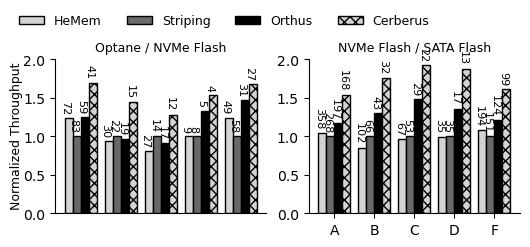

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
result_dir = "result3"
# latency is in microsecond
hierarchy = ["optane_nvme", "nvme_sata"]
# workload = ["workloada", "workloadb", "workloadc", "workloadd", "workloade", "workloadf"]
workload = ["workloada", "workloadb", "workloadc", "workloadd", "workloadf"] 
mode_list = ["tiering", "striping", "caching", "most"]
color_list = [ 'lightgrey', 'dimgray', 'black', 'lightgray']
label_list = ['HeMem', 'Striping', 'Orthus', 'Cerberus']
hatch_list = ['', '', '', 'xxx']

fig, axes = plt.subplots(1, 2, figsize=(6, 2))

for h_idx, h in enumerate(hierarchy):
  result = {}
  for w in workload:
    base_dir = os.path.join(result_dir, h, w)
    for file_name in os.listdir(base_dir):
      if file_name.endswith('.result'):
        tokens = file_name.split('.')[0].split('_')
        mode = tokens[1]
        tp, read_avg, read_p99,_,_,_,_ = parse_log_file(os.path.join(base_dir, file_name))
        if mode not in result:
          result[mode] = {}
          result[mode]["tp"] = []
          result[mode]["avg"] = []
          result[mode]["p99"] = []
        
        # if w == "workloadd":
        #   start_idx = -8
        #   end_idx = -3
        # elif w == "workloadb":
        #   start_idx = -10
        #   end_idx = -4
        # else:
        start_idx = -4
        # end_idx = -2
        # print(tp[start_idx:end_idx])

        result[mode]["tp"].append(np.mean(tp[start_idx:-1]))
        result[mode]["avg"].append(np.mean(read_avg[int(start_idx/2):-1]))
        result[mode]["p99"].append(np.mean(read_p99[int(start_idx/2):-1]))

  X = np.array(range(len(workload)))
  width= 0.2
  baseline="striping"
  for idx, mode in enumerate(mode_list):
    print(mode, result[mode]["tp"], result[mode]["avg"], result[mode]["p99"])
    tp_improvement = (np.array(result[mode]["tp"]) - result[baseline]["tp"])/ result[baseline]["tp"]
    avg_lat_improvement = (np.array(result[mode]["avg"]) - result[baseline]["avg"])/ result[baseline]["avg"]
    p99_lat_improvement = (np.array(result[mode]["p99"]) - result[baseline]["p99"])/ result[baseline]["p99"]
    # print(mode)
    # print("Throughput", np.mean(tp_improvement), tp_improvement) 
    # print("Average Latency", np.mean(avg_lat_improvement), avg_lat_improvement) 
    # print("P99 Latency", np.mean(p99_lat_improvement), p99_lat_improvement) 
    collection = axes[h_idx].bar(X - 3/2 * width + idx *width, np.array(result[mode]["tp"]) /result["striping"]["tp"], width=width, color=color_list[idx], label=label_list[idx], edgecolor='black', hatch=hatch_list[idx])
    for index, bar in enumerate(collection):
      yval = bar.get_height()
      # print(index, )
      
      axes[h_idx].text(bar.get_x() + bar.get_width() * 0.2 / 2, yval+0.05, int(result[mode]["p99"][index]), ha='center', va='bottom', fontsize=8, rotation=-90)
labels = {
  "workloada": "A",
  "workloadb": "B",
  "workloadc": "C",
  "workloadd": "D",
  "workloade": "E",
  "workloadf": "F"
}

axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].set_title("Optane / NVMe Flash", fontsize=9)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

axes[0].set_ylim(0, 2)
axes[1].set_ylim(0, 2)


axes[0].set_xticks([])
axes[1].set_xticks(X)
axes[1].set_xticklabels([labels[x] for x in workload])
# axes[1].set_xlabel("YCSB Workload")
axes[1].set_title("NVMe Flash / SATA Flash", fontsize=9)

# axes[0].legend(frameon=False, ncol=2)
axes[0].legend(
    frameon=False, fontsize=9, ncol=4, loc="center", bbox_to_anchor=(0.8, 1.25)
)
fig.text(
    0.05,
    0.5,
    "Normalized Throughput",
    va="center",
    rotation="vertical",
    fontsize=9,
)



fig.savefig("ycsb_1k.jpg", dpi=1200, bbox_inches='tight')




In [19]:
# base_dir = "result3/nvme_sata/workloadf/workloadf_most_nvme_sata_256_10000000.result"
# parse_log_file(base_dir)

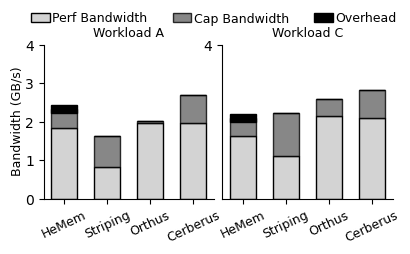

In [87]:
import os
import numpy as np
import matplotlib.pyplot as plt

result_dir = "result3"
# latency is in microsecond
h= "optane_nvme"
# workload = ["workloada", "workloadb", "workloadc", "workloadd", "workloade", "workloadf"]
workload = ["workloada", "workloadc"] 
mode_list = ["tiering", "striping", "caching", "most"]
color_list = [ 'lightgrey', 'dimgray', 'black', 'lightgray']
label_list = ['HeMem', 'Striping', 'Orthus', 'Cerberus']
hatch_list = ['', '', '', 'xxx']

fig, axes = plt.subplots(1, 2, figsize=(4.5, 2))


for w_idx, w in enumerate(workload):
  result = {}
  base_dir = os.path.join(result_dir, h, w)
  for file_name in os.listdir(base_dir):
    if file_name.endswith('.result'):
      tokens = file_name.split('.')[0].split('_')
      mode = tokens[1]
      _ , _ , _, perf, cap,_,_ = parse_log_file(os.path.join(base_dir, file_name))
      if mode not in result:
        result[mode] = {}
        result[mode]["perf"] = []
        result[mode]["cap"] = []
      

      # print(perf,)
      start_idx = -8

      end_idx = -6
      # print(tp[start_idx:end_idx])

      result[mode]["perf"].append(np.mean(perf[start_idx:end_idx])/1024)
      result[mode]["cap"].append(np.mean(cap[int(start_idx):end_idx])/1024)

  X = np.array(range(len(workload)))
  width= 0.3
  for idx, mode in enumerate(mode_list):
    # print(mode, result[mode]["tp"], result[mode]["avg"], result[mode]["p99"])
    # print(mode, (np.array(result[mode]["tp"]) - result["tiering"]["tp"])/ result["tiering"]["tp"], (np.array(result[mode]["avg"]) - result["tiering"]["avg"])/ result["tiering"]["avg"], (np.array(result[mode]["p99"]) - result["tiering"]["p99"])/ result["tiering"]["p99"]) 

    overhead=0.2 if idx == 0 else 0
    if idx == 0:
      axes[w_idx].bar(idx/2, np.array(result[mode]["perf"]) - overhead/2, width=width, color="lightgray", label="Perf Bandwidth", edgecolor='black')
      axes[w_idx].bar(idx/2, np.array(result[mode]["cap"]), bottom=np.array(result[mode]["perf"])-overhead/2, width=width, color="dimgray", label="Cap Bandwidth", alpha=0.8, edgecolor='black')
      axes[w_idx].bar(idx/2, overhead, bottom=np.array(result[mode]["perf"]) + np.array(result[mode]["cap"])-overhead, width=width, color="black", label="Overhead", edgecolor='black')
    else:
      axes[w_idx].bar(idx/2, np.array(result[mode]["perf"]) - overhead/2, width=width, color="lightgray",  edgecolor='black')
      axes[w_idx].bar(idx/2, np.array(result[mode]["cap"]), bottom=np.array(result[mode]["perf"])-overhead/2, width=width, color="dimgray",  alpha=0.8, edgecolor='black')
      axes[w_idx].bar(idx/2, overhead, bottom=np.array(result[mode]["perf"]) + np.array(result[mode]["cap"])-overhead, width=width, color="black",  edgecolor='black')



labels = {
  "workloada": "A",
  "workloadb": "B",
  "workloadc": "C",
  "workloadd": "D",
  "workloade": "E",
  "workloadf": "F"
}

axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].set_ylim(0, 4)
axes[0].set_xticks([0, 0.5, 1, 1.5])
axes[0].set_xticklabels(["HeMem", "Striping", "Orthus", "Cerberus"], fontsize=9, rotation=25)
axes[0].set_title("Workload A", fontsize=9)

axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].set_ylim(0, 4)
axes[1].set_yticks([4])
axes[1].set_xticks([0, 0.5, 1, 1.5])
axes[1].set_xticklabels(["HeMem", "Striping", "Orthus", "Cerberus"], fontsize=9, rotation=25)
axes[1].set_title("Workload C", fontsize=9)



# axes[0].set_title("Optane / NVMe Flash", fontsize=9)
# axes[1].spines['right'].set_visible(False)
# axes[1].spines['top'].set_visible(False)


# axes[1].set_ylim(0, 4)


# axes[0].set_xticks([])
# axes[1].set_xticks(X)
# axes[1].set_xticklabels([labels[x] for x in workload])
# # axes[1].set_xlabel("YCSB Workload")
# axes[1].set_title("NVMe Flash / SATA Flash", fontsize=9)

# # axes[0].legend(frameon=False, ncol=2)
# axes[0].legend(
#     frameon=False, fontsize=9, ncol=4, loc="center", bbox_to_anchor=(0.5, 1.25)
# )
# fig.text(
#     0.05,
#     0.5,
#     "Normalized Throughput",
#     va="center",
#     rotation="vertical",
#     fontsize=9,
# )
axes[0].legend(
    frameon=False, fontsize=9, ncol=3, loc="center", bbox_to_anchor=(1, 1.17), labelspacing=0.2, handlelength=1.5, handletextpad=0.2, borderpad=0.2,
)
fig.text(
    0.05,
    0.5,
    "Bandwidth (GB/s)",
    va="center",
    rotation="vertical",
    fontsize=9,
)
plt.subplots_adjust(wspace=0.05)
fig.savefig("ycsb_breakdown.jpg", dpi=1200, bbox_inches='tight')




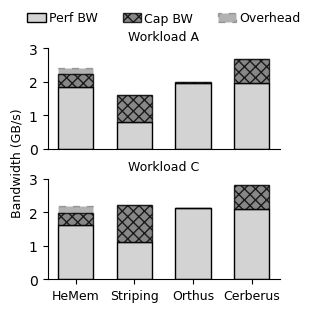

In [100]:
import os
import numpy as np
import matplotlib.pyplot as plt

result_dir = "result3"
# latency is in microsecond
h= "optane_nvme"
# workload = ["workloada", "workloadb", "workloadc", "workloadd", "workloade", "workloadf"]
workload = ["workloada", "workloadc"] 
mode_list = ["tiering", "striping", "caching", "most"]
color_list = [ 'lightgrey', 'dimgray', 'black', 'lightgray']
label_list = ['HeMem', 'Striping', 'Orthus', 'Cerberus']
hatch_list = ['', '', '', 'xxx']

fig, axes = plt.subplots(2, 1, figsize=(3, 3))


for w_idx, w in enumerate(workload):
  result = {}
  base_dir = os.path.join(result_dir, h, w)
  for file_name in os.listdir(base_dir):
    if file_name.endswith('.result'):
      tokens = file_name.split('.')[0].split('_')
      mode = tokens[1]
      _ , _ , _, perf, cap,_,_ = parse_log_file(os.path.join(base_dir, file_name))
      if mode not in result:
        result[mode] = {}
        result[mode]["perf"] = []
        result[mode]["cap"] = []
      

      # print(perf,)
      start_idx = -4

      end_idx = -1
      # print(tp[start_idx:end_idx])

      result[mode]["perf"].append(np.mean(perf[start_idx:end_idx])/1024)
      result[mode]["cap"].append(np.mean(cap[int(start_idx):end_idx])/1024)

  X = np.array(range(len(workload)))
  width= 0.3
  for idx, mode in enumerate(mode_list):
    # print(mode, result[mode]["tp"], result[mode]["avg"], result[mode]["p99"])
    # print(mode, (np.array(result[mode]["tp"]) - result["tiering"]["tp"])/ result["tiering"]["tp"], (np.array(result[mode]["avg"]) - result["tiering"]["avg"])/ result["tiering"]["avg"], (np.array(result[mode]["p99"]) - result["tiering"]["p99"])/ result["tiering"]["p99"]) 

    overhead=0.2 if idx == 0 else 0
    if idx == 0:
      axes[w_idx].bar(idx/2, np.array(result[mode]["perf"]) - overhead/2, width=width, color="lightgray", label="Perf BW", edgecolor='black')
      axes[w_idx].bar(idx/2, np.array(result[mode]["cap"])-overhead/2, bottom=np.array(result[mode]["perf"])-overhead/2, width=width, color="dimgray", label="Cap BW", alpha=0.8, edgecolor='black', hatch='xxx')
      bars = axes[w_idx].bar(idx/2, overhead, bottom=np.array(result[mode]["perf"]) + np.array(result[mode]["cap"])-overhead, width=width, color="black", alpha=0.3, label="Overhead", edgecolor='black', )
      for bar in bars:
        bar.set_linestyle((0, (5, 5)))  # Set dashed line: (length of dash, length of gap)
    else:
      axes[w_idx].bar(idx/2, np.array(result[mode]["perf"]) - overhead/2, width=width, color="lightgray",  edgecolor='black')
      axes[w_idx].bar(idx/2, np.array(result[mode]["cap"]) - overhead/2, bottom=np.array(result[mode]["perf"])-overhead/2, width=width, color="dimgray",  alpha=0.8, edgecolor='black', hatch='xxx')
      axes[w_idx].bar(idx/2, overhead, bottom=np.array(result[mode]["perf"]) + np.array(result[mode]["cap"])-overhead, width=width, color="black",  alpha=0.3, edgecolor='black')
      for bar in bars:
        bar.set_linestyle((0, (5, 5)))  # Set dashed line: (length of dash, length of gap)



labels = {
  "workloada": "A",
  "workloadb": "B",
  "workloadc": "C",
  "workloadd": "D",
  "workloade": "E",
  "workloadf": "F"
}

axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].set_ylim(0, 3)
axes[0].set_xticks([])
# axes[0].set_xticks([0, 0.5, 1, 1.5])
# axes[0].set_xticklabels(["HeMem", "Striping", "Orthus", "Cerberus"], fontsize=9, rotation=25)
axes[0].set_title("Workload A", fontsize=9)

axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].set_ylim(0, 3)
# axes[1].set_yticks([0,   4])
axes[1].set_xticks([0, 0.5, 1, 1.5])
axes[1].set_xticklabels(["HeMem", "Striping", "Orthus", "Cerberus"], fontsize=9, rotation=0)
axes[1].set_title("Workload C", fontsize=9)



# axes[0].set_title("Optane / NVMe Flash", fontsize=9)
# axes[1].spines['right'].set_visible(False)
# axes[1].spines['top'].set_visible(False)


# axes[1].set_ylim(0, 4)


# axes[0].set_xticks([])
# axes[1].set_xticks(X)
# axes[1].set_xticklabels([labels[x] for x in workload])
# # axes[1].set_xlabel("YCSB Workload")
# axes[1].set_title("NVMe Flash / SATA Flash", fontsize=9)

# # axes[0].legend(frameon=False, ncol=2)
# axes[0].legend(
#     frameon=False, fontsize=9, ncol=4, loc="center", bbox_to_anchor=(0.5, 1.25)
# )
# fig.text(
#     0.05,
#     0.5,
#     "Normalized Throughput",
#     va="center",
#     rotation="vertical",
#     fontsize=9,
# )
axes[0].legend(
    frameon=False, fontsize=9, ncol=3, loc="center", bbox_to_anchor=(0.5, 1.3), labelspacing=0.1, handlelength=1.5, handletextpad=0.2, borderpad=0.2,
)
fig.text(
    0,
    0.5,
    "Bandwidth (GB/s)",
    va="center",
    rotation="vertical",
    fontsize=9,
)
plt.subplots_adjust(hspace=0.3)
fig.savefig("ycsb_breakdown.jpg", dpi=1200, bbox_inches='tight')




{'striping': {'tp': [702622.5, 493317.0, 386315.5, 308174.0, 255168.5], 'hit_ratio': [96.1579475, 88.77380500000001, 81.13195150000001, 73.46450250000001, 66.955663], 'p99': [14.47, 18.56, 20.43, 21.79, 22.53]}, 'tiering': {'tp': [575873.5, 447185.0, 391489.0, 320644.5, 279232.0], 'hit_ratio': [96.7556875, 90.528539, 83.6140165, 76.901235, 70.6231885], 'p99': [25.97, 30.08, 33.89, 33.41, 32.66]}, 'caching': {'tp': [844192.5, 537659.5, 382737.5, 276973.0, 210060.5], 'hit_ratio': [92.91756750000002, 80.8511575, 70.2108655, 62.59188, 55.646004999999995], 'p99': [11.54, 13.49, 15.33, 17.34, 19.47]}, 'most': {'tp': [891868.0, 712374.5, 582120.5, 464258.0, 379404.0], 'hit_ratio': [96.613687, 90.005896, 83.25259299999999, 76.081055, 70.03811200000001], 'p99': [11.91, 14.11, 15.46, 16.75, 16.53]}}


TypeError: 'AxesSubplot' object is not subscriptable

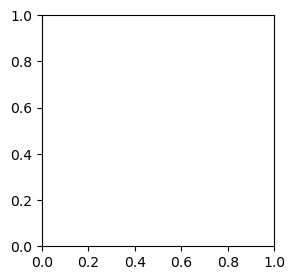

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
result_dir = "hit_ratio"
# latency is in microsecond
hierarchy = ["optane_nvme"]
# workload = ["workloada", "workloadb", "workloadc", "workloadd", "workloade", "workloadf"]
workload = [ "workloadc"] 
mode_list = ["tiering", "striping", "caching", "most"]
color_list = [ 'lightgrey', 'dimgray', 'black', 'lightgray']
label_list = ['HeMem', 'Striping', 'Orthus', 'Cerberus']
hatch_list = ['', '', '', 'xxx']
marker_list = ['|', 'x',  'x', '_']
record_num_list = [10, 20, 30, 40, 50]
fig, axes = plt.subplots(1, 1, figsize=(3, 3))
# Function to extract the number before ".json"
def get_number_from_filename(filename):
    # print(filename)
    # Using regex to find the last number in the filename before ".json"
    record_num = int(filename.split('.')[0].split('_')[-1])
    return record_num


result={}
base_dir = os.path.join(result_dir, "optane_nvme", "workloadc")
files = os.listdir(base_dir)
# print(files)
sorted_files = sorted(files, key=get_number_from_filename)
for file_name in sorted_files:
  # print(file_name)
  if file_name.endswith('.result'):
    tokens = file_name.split('.')[0].split('_')
    mode = tokens[1]
    record_num = int(int(tokens[5])/1000000)
    if record_num not in record_num_list or mode not in mode_list:
      continue
    tp, read_avg, read_p99,_,_,dram_hit,nvm_hit = parse_log_file(os.path.join(base_dir, file_name))
    if mode not in result:
      result[mode] = {}
      result[mode]["tp"] = []
      result[mode]["hit_ratio"] = []
      result[mode]["p99"] = []
    start_idx = -6
    end_idx = -4
    # print(tp[start_idx:end_idx])

    result[mode]["tp"].append(np.mean(tp[start_idx:end_idx]))
    result[mode]["p99"].append(np.mean(read_p99[-3:-2]))
    dram_hit_ratio = np.mean(dram_hit[int(start_idx):end_idx])
    nvm_hit_ratio = np.mean(nvm_hit[int(start_idx):end_idx])
    result[mode]["hit_ratio"].append(dram_hit_ratio + nvm_hit_ratio * (100 - dram_hit_ratio)/ 100)

X = np.array(range(len(record_num_list)))
width= 0.2
print(result)

# baseline="s"
for idx, mode in enumerate(mode_list):
  # print(mode, result[mode]["tp"], result[mode]["avg"], result[mode]["p99"])
  # tp_improvement = (np.array(result[mode]["tp"]) - result[baseline]["tp"])/ result[baseline]["tp"]
  # avg_lat_improvement = (np.array(result[mode]["avg"]) - result[baseline]["avg"])/ result[baseline]["avg"]
  # p99_lat_improvement = (np.array(result[mode]["p99"]) - result[baseline]["p99"])/ result[baseline]["p99"]
  # print(mode)
  # print("Throughput", np.mean(tp_improvement), tp_improvement) 
  # print("Average Latency", np.mean(avg_lat_improvement), avg_lat_improvement) 
  # print("P99 Latency", np.mean(p99_lat_improvement), p99_lat_improvement) 

  # collection = axes[h_idx].bar(X - 3/2 * width + idx *width, np.array(result[mode]["tp"]) /result["striping"]["tp"], width=width, color=color_list[idx], label=label_list[idx], edgecolor='black', hatch=hatch_list[idx])
  
  collection = axes[1].bar(X - 3/2 * width + idx *width, np.array(result[mode]["tp"])/1000000,width=width, color=color_list[idx], label=label_list[idx], edgecolor='black', hatch=hatch_list[idx] )
  for index, bar in enumerate(collection):
    yval = bar.get_height()
    # print(index, )
    axes[0].text(bar.get_x() + bar.get_width() * 0.3 / 2, yval+0.1, int(result[mode]["hit_ratio"][index]), ha='center', va='bottom', fontsize=8, rotation=-90)
  print(mode, result[mode]["hit_ratio"])
  # axes[0].bar(X - 3/2 * width + idx *width, np.array(result[mode]["hit_ratio"])/100, width=width, color=color_list[idx], label=label_list[idx], edgecolor='black', hatch=hatch_list[idx] )

  # axes[0].plot(record_num_list, np.array(result[mode]["hit_ratio"])/100, label=label_list[idx], marker=marker_list[idx] )
  # axes[1].plot(record_num_list, np.array(result[mode]["tp"])/1000000, label=label_list[idx], marker='^')
labels = {
  "workloada": "A",
  "workloadb": "B",
  "workloadc": "C",
  "workloadd": "D",
  "workloade": "E",
  "workloadf": "F"
}

axes[0].legend(frameon=False, fontsize=9, labelspacing=0.2, handlelength=1.5, handletextpad=0.2, borderpad=0.2)
axes[0].set_xticks([])
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
# axes[0].set_title("Optane / NVMe Flash", fontsize=9)
axes[0].set_ylabel("Hit Ratio", fontsize=9)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].set_ylabel("Throughput (Mops)", fontsize=9)
axes[1].legend(frameon=False, fontsize=8, ncol=2, labelspacing=0.2, handlelength=1.5, handletextpad=0.2, borderpad=0.2)

# axes[0].set_xticks(X)
# axes[0].set_xticklabels([labels[x] for x in workload], fontsize=9)
axes[1].set_xticks(X)
axes[1].set_xticklabels(np.array(record_num_list),fontsize=9)
axes[1].set_xlabel("Record Number (Millions of Keys)", fontsize=9)

# axes[1].set_yticks([4.0])

# # axes[1].set_xlabel("YCSB Workload")
# axes[1].set_title("NVMe Flash / SATA Flash", fontsize=9)

# # axes[0].legend(frameon=False, ncol=2)
# axes[0].legend(
#     frameon=False, fontsize=9, ncol=4, loc="center", bbox_to_anchor=(1, 1.15)
# )
# fig.text(
#     0.05,
#     0.5,
#     "Normalized Throughput",
#     va="center",
#     rotation="vertical",
#     fontsize=9,
# )

plt.subplots_adjust(wspace=0.05)
# fig.tight_layout()

fig.savefig("ycsb_1k.jpg", dpi=1200, bbox_inches='tight')


{'striping': {'tp': [702598.6666666666, 495592.3333333333, 386577.0, 307996.0, 255093.0], 'hit_ratio': [96.2248, 88.86968200000001, 81.24952299999998, 73.57594, 67.05740233333333], 'p99': [14.47, 18.56, 20.43, 21.79, 22.53]}, 'tiering': {'tp': [555075.0, 452610.0, 391793.0, 319376.6666666667, 278389.3333333333], 'hit_ratio': [96.81205333333334, 90.61727133333333, 83.740297, 77.02307333333333, 70.7532], 'p99': [25.97, 30.08, 33.89, 33.41, 32.66]}, 'caching': {'tp': [844036.3333333334, 538588.6666666666, 382702.6666666667, 276986.3333333333, 210085.66666666666], 'hit_ratio': [93.11288166666667, 81.113, 70.482296, 62.670602666666674, 55.704336], 'p99': [11.54, 13.49, 15.33, 17.34, 19.47]}, 'most': {'tp': [894173.0, 712439.6666666666, 582123.3333333334, 464178.0, 380357.3333333333], 'hit_ratio': [96.704146, 90.17475400000001, 83.44709399999999, 76.28312833333332, 70.21763200000001], 'p99': [11.91, 14.11, 15.46, 16.75, 16.53]}}
tiering [96.81205333333334, 90.61727133333333, 83.740297, 77.02

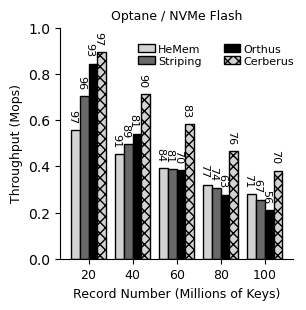

: 

In [111]:
import os
import numpy as np
import matplotlib.pyplot as plt
result_dir = "hit_ratio"
# latency is in microsecond
hierarchy = ["optane_nvme"]
# workload = ["workloada", "workloadb", "workloadc", "workloadd", "workloade", "workloadf"]
workload = [ "workloadc"] 
mode_list = ["tiering", "striping", "caching", "most"]
color_list = [ 'lightgrey', 'dimgray', 'black', 'lightgray']
label_list = ['HeMem', 'Striping', 'Orthus', 'Cerberus']
hatch_list = ['', '', '', 'xxx']
marker_list = ['|', 'x',  'x', '_']
record_num_list = [10, 20, 30, 40, 50]
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# Function to extract the number before ".json"
def get_number_from_filename(filename):
    # print(filename)
    # Using regex to find the last number in the filename before ".json"
    record_num = int(filename.split('.')[0].split('_')[-1])
    return record_num


result={}
base_dir = os.path.join(result_dir, "optane_nvme", "workloadc")
files = os.listdir(base_dir)
# print(files)
sorted_files = sorted(files, key=get_number_from_filename)
for file_name in sorted_files:
  # print(file_name)
  if file_name.endswith('.result'):
    tokens = file_name.split('.')[0].split('_')
    mode = tokens[1]
    record_num = int(int(tokens[5])/1000000)
    if record_num not in record_num_list or mode not in mode_list:
      continue
    tp, read_avg, read_p99,_,_,dram_hit,nvm_hit = parse_log_file(os.path.join(base_dir, file_name))
    if mode not in result:
      result[mode] = {}
      result[mode]["tp"] = []
      result[mode]["hit_ratio"] = []
      result[mode]["p99"] = []
    start_idx = -4
    end_idx = -1
    # print(tp[start_idx:end_idx])

    result[mode]["tp"].append(np.mean(tp[start_idx:end_idx]))
    result[mode]["p99"].append(np.mean(read_p99[-3:-2]))
    dram_hit_ratio = np.mean(dram_hit[int(start_idx):end_idx])
    nvm_hit_ratio = np.mean(nvm_hit[int(start_idx):end_idx])
    result[mode]["hit_ratio"].append(dram_hit_ratio + nvm_hit_ratio * (100 - dram_hit_ratio)/ 100)

X = np.array(range(len(record_num_list)))
width= 0.2
print(result)

# baseline="s"
for idx, mode in enumerate(mode_list):
  # print(mode, result[mode]["tp"], result[mode]["avg"], result[mode]["p99"])
  # tp_improvement = (np.array(result[mode]["tp"]) - result[baseline]["tp"])/ result[baseline]["tp"]
  # avg_lat_improvement = (np.array(result[mode]["avg"]) - result[baseline]["avg"])/ result[baseline]["avg"]
  # p99_lat_improvement = (np.array(result[mode]["p99"]) - result[baseline]["p99"])/ result[baseline]["p99"]
  # print(mode)
  # print("Throughput", np.mean(tp_improvement), tp_improvement) 
  # print("Average Latency", np.mean(avg_lat_improvement), avg_lat_improvement) 
  # print("P99 Latency", np.mean(p99_lat_improvement), p99_lat_improvement) 

  # collection = axes[h_idx].bar(X - 3/2 * width + idx *width, np.array(result[mode]["tp"]) /result["striping"]["tp"], width=width, color=color_list[idx], label=label_list[idx], edgecolor='black', hatch=hatch_list[idx])
  
  collection = ax.bar(X - 3/2 * width + idx *width, np.array(result[mode]["tp"])/1000000,width=width, color=color_list[idx], label=label_list[idx], edgecolor='black', hatch=hatch_list[idx] )
  for index, bar in enumerate(collection):
    yval = bar.get_height()
    # print(index, )
    ax.text(bar.get_x() + bar.get_width() * 0.25 / 2, yval+0.03, int(round(result[mode]["hit_ratio"][index], 0)), ha='center', va='bottom', fontsize=8, rotation=-90)
  print(mode, result[mode]["hit_ratio"])
  # axes[0].bar(X - 3/2 * width + idx *width, np.array(result[mode]["hit_ratio"])/100, width=width, color=color_list[idx], label=label_list[idx], edgecolor='black', hatch=hatch_list[idx] )

  # axes[0].plot(record_num_list, np.array(result[mode]["hit_ratio"])/100, label=label_list[idx], marker=marker_list[idx] )
  # axes[1].plot(record_num_list, np.array(result[mode]["tp"])/1000000, label=label_list[idx], marker='^')
labels = {
  "workloada": "A",
  "workloadb": "B",
  "workloadc": "C",
  "workloadd": "D",
  "workloade": "E",
  "workloadf": "F"
}

# axes[0].legend(frameon=False, fontsize=9, labelspacing=0.2, handlelength=1.5, handletextpad=0.2, borderpad=0.2)
# axes[0].set_xticks([])
# axes[0].spines['right'].set_visible(False)
# axes[0].spines['top'].set_visible(False)
# # axes[0].set_title("Optane / NVMe Flash", fontsize=9)
# axes[0].set_ylabel("Hit Ratio", fontsize=9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# axes[0].set_ylim(0, 1)
ax.set_ylim(0, 1)
ax.set_ylabel("Throughput (Mops)", fontsize=9)
ax.legend(frameon=False, fontsize=8, ncol=2, labelspacing=0.2, handlelength=1.5, handletextpad=0.3, borderpad=0.2, bbox_to_anchor=(0.3, 0.8))

# axes[0].set_xticks(X)
# axes[0].set_xticklabels([labels[x] for x in workload], fontsize=9)
ax.set_xticks(X)
ax.set_xticklabels(np.array(record_num_list) * 2,fontsize=9)
ax.set_xlabel("Record Number (Millions of Keys)", fontsize=9)
ax.set_title("Optane / NVMe Flash", fontsize=9)
# axes[1].set_yticks([4.0])

# # axes[1].set_xlabel("YCSB Workload")
# axes[1].set_title("NVMe Flash / SATA Flash", fontsize=9)

# # axes[0].legend(frameon=False, ncol=2)
# axes[0].legend(
#     frameon=False, fontsize=9, ncol=4, loc="center", bbox_to_anchor=(1, 1.15)
# )
# fig.text(
#     0.05,
#     0.5,
#     "Normalized Throughput",
#     va="center",
#     rotation="vertical",
#     fontsize=9,
# )

plt.subplots_adjust(wspace=0.05)
# fig.tight_layout()

fig.savefig("ycsb_hit_ratio.jpg", dpi=1200, bbox_inches='tight')


result3/optane_nvme/workloadd/workloadd_most_optane_nvme_256_10000000.error


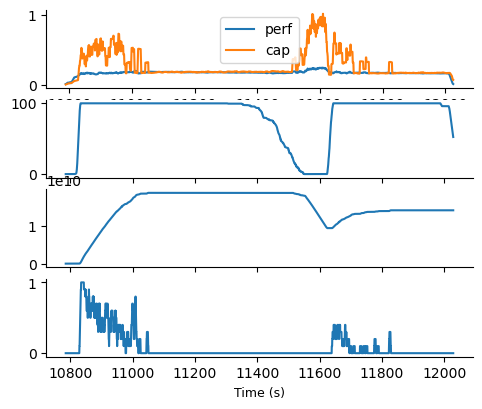

In [33]:
import numpy as np
import pandas as pd

def smooth_data(data, window=1):
    s = pd.Series(data)
    smoothed_data = s.rolling(window=window
                              ).mean().tolist()
    return smoothed_data

def extract_data_within_timestamps(timestamps, data, start_timestamp, end_timestamp):
    extracted_timestamps = [t for t in timestamps if start_timestamp <= t <= end_timestamp]
    extracted_data = [d for t, d in zip(timestamps, data) if start_timestamp <= t <= end_timestamp]
    
    return extracted_timestamps, extracted_data

fontsize=9
def fill_area(ax, x_start, x_end, y_max):
    # Define the range and function
    x = np.linspace(x_start, x_end, 1000)  # Ensuring the graph goes a little beyond our range of interest
    y = np.full_like(x, y_max) 
    ax.fill_between(x, y, where=[x_start <= xi <= x_end for xi in x], color='dimgray', label='Shaded Area', alpha=0.2)


def throughput_vs_time(exp_dirs, starting_point, ending_point, title, dir='result_minimal', exp_name='dynamic'):
    figure, axes = plt.subplots(4, 1, figsize=(5.5, 4.5))
    figure.suptitle(title)
    shift = 55
    # linestyle_list = ['solid', (0, (1, 1))]
    linestyle_list = ['-', '--']
    color_list = ['black', 'dimgray']
    label_list = ['Cerberus', 'Classic Tiering (HeMem)']
    
    # exp_base_dir = os.path.join(f'../{dir}', exp_name)
    # exp_dir = os.path.join(exp_base_dir, exp_dir)
    # copy_structure_to_destination(exp_dir, '../result_minimal/')
    # filename_list = os.listdir(exp_dir)
    # filename_list.sort()
    hbr_size_list = []
    migration_up_list = []
    migration_down_list = []
    split_ratio_list = []
    p_timestamp_list = []

    hbr_size_list = []
    get_throughput_list = []
    set_throughput_list = []
    tp_timestamp_list = []
    la_timestamp_list = []
    migration_timestamp_list = []
    perf_await_list = []
    cap_await_list = []
    migration_list = []
    

    perf_tp_list = []
    cap_tp_list = []
    fast_read_throughput = []
    slow_read_throughput = []
    for filename in [os.path.join("result3", "optane_nvme", "workloadd", "workloadd_most_optane_nvme_256_10000000.error")]:
        print(filename)
        if filename.endswith('.error'):
            with open(filename) as f:
                for line in f:
                    if line.endswith("***\n"):
                        tokens = line.split()
                        migration_down = 1 if tokens[-2] == 'true' else 0 
                        migration_up = 1 if tokens[-3] == 'true' else 0 
                        split_ratio = int(tokens[-4])
                        HBR_size = int(tokens[-8])
                        timestamps =  int(tokens[-9])
                        hbr_size_list.append(HBR_size)
                        p_timestamp_list.append(timestamps)
                        split_ratio_list.append(split_ratio)
                        migration_down_list.append(migration_down)
                        migration_up_list.append(migration_up)
                    elif line.endswith("^^^\n"):
                        tokens = line.split()
                        try:
                            timestamp = float(tokens[-8])
                            fast_lat = float(tokens[-7])
                            slow_lat = float(tokens[-6])        
                        except:
                            timestamp = 0
                            fast_lat= 0
                            slow_lat = 0
                        la_timestamp_list.append(timestamp)
                        perf_await_list.append(fast_lat)
                        cap_await_list.append(slow_lat)
                    elif line.endswith("@@@\n"):
                        tokens = line.split()
                        try:
                            timestamp = float(tokens[-5])
                            migration = float(tokens[-2]) / 1024 /1024 / 1024
                        except:
                            timestamp = 0
                            migration = 0
                        migration_timestamp_list.append(timestamp)
                        migration_list.append(migration)

    # print(migration_down_list)
    # print(migration_up_list)
    # print(perf_await_list)
    # print(cap_await_list)
    axes[0].plot(smooth_data(la_timestamp_list, 10), smooth_data(perf_await_list, 10), label="perf")
    axes[0].plot(smooth_data(la_timestamp_list, 10), smooth_data(cap_await_list, 10), label="cap")
    axes[0].legend()


    axes[1].plot(smooth_data(p_timestamp_list, 10), smooth_data(split_ratio_list, 10))
    axes[2].plot(smooth_data(p_timestamp_list, 10), smooth_data(hbr_size_list, 10))


    # axes[3].plot(migration_timestamp_list, migration_list)
    axes[3].plot(smooth_data(p_timestamp_list, 10), smooth_data(migration_up_list, 10), label="perf")
    # axes[3].plot(smooth_data(p_timestamp_list, 10), smooth_data(migration_down_list, 10), label="cap")


    # migration_down_list.append(migration_down)
    # migration_up_list.append(migration_up)
    # axes[1].plot(la_timestamp_list, cap_await_list)
        
        # min_timestamp = min(p_timestamp_list[0], tp_timestamp_list[0])
        # p_timestamp_list = np.array(p_timestamp_list) - min_timestamp
        # la_timestamp_list = np.array(la_timestamp_list) - min_timestamp
        # tp_timestamp_list = np.array(tp_timestamp_list) - min_timestamp
        # migration_timestamp_list = np.array(migration_timestamp_list) - min_timestamp
        

        # # Throughput 
        # extracted_timestamp, throughput_list = extract_data_within_timestamps(tp_timestamp_list, throughput_list, starting_point, ending_point)
        # extracted_timestamp, perf_tp_list = extract_data_within_timestamps(tp_timestamp_list, perf_tp_list, starting_point, ending_point)
        # extracted_timestamp, cap_tp_list = extract_data_within_timestamps(tp_timestamp_list, cap_tp_list, starting_point, ending_point)
        # axes[0].plot(smooth_data(np.array(extracted_timestamp) - starting_point, window=1), smooth_data(np.array(throughput_list) / 1000, window=1), linestyle=linestyle_list[idx], color=color_list[idx], label=label_list[idx])
        

        # # print(len(throughput_list))
        # axes[0].set_xticks([])
        # axes[0].set_xlim(0, ending_point - starting_point)
        # axes[0].set_ylabel("Tp (KOps/s)", fontsize=fontsize)
        # axes[0].set_ylim(0, 210)
        # axes[0].legend(frameon=False, loc='lower right', fontsize=fontsize)

        # if mode == 'tiering':
        #     continue
        # # axes[1].plot(smooth_data(np.array(extracted_timestamp) - starting_point, window=1), smooth_data(np.array(perf_tp_list) / 1000, window=1),  color='black', linestyle='-', label='Optane')
        # # axes[1].plot(smooth_data(np.array(extracted_timestamp) - starting_point, window=1), smooth_data(np.array(cap_tp_list) / 1000, window=1),  color='gray', linestyle='-', label='NVMe')
        # # axes[1].set_ylabel("BW (GB/s)", fontsize=fontsize)
        # # axes[1].set_ylim(0, 3)
        # # axes[1].set_xticks([])
        # # axes[1].set_xlim(0, ending_point - starting_point)
        # # axes[1].legend(frameon=False, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.25), fontsize=fontsize)

        # # Latency 
        # # print(la_timestamp_list, tp_timestamp_list)
        # extracted_timestamp, perf_await_list = extract_data_within_timestamps(la_timestamp_list, perf_await_list, starting_point, ending_point)
        # extracted_timestamp, cap_await_list = extract_data_within_timestamps(la_timestamp_list, cap_await_list, starting_point, ending_point)
        # axes[1].plot(smooth_data(np.array(extracted_timestamp)  - starting_point, window=1), smooth_data(perf_await_list, window=1), color='black', linestyle='-', label='Optane')
        # axes[1].plot(smooth_data(np.array(extracted_timestamp) - starting_point, window=1), smooth_data(cap_await_list, window=1), color='gray', linestyle='-', label='NVMe')
        # axes[1].set_xticks([])
        # axes[1].set_ylim(0, 1.0)
        # axes[1].set_yticks([0, 0.5, 1])
        # axes[1].set_yticklabels([0, 0.5, 1])
        
        # axes[1].set_xlim(0, ending_point - starting_point)
        # axes[1].set_ylabel("Lat (ms)", fontsize=fontsize)
        # axes[1].legend(frameon=False, loc='upper right', fontsize=fontsize)
      
        # # Caching Class Size
        # # extracted_timestamp, hbr_size_list = extract_data_within_timestamps(p_timestamp_list, hbr_size_list, starting_point, ending_point)
        # # _, migration_down_list = extract_data_within_timestamps(p_timestamp_list, migration_down_list, starting_point, ending_point)
        # # _, migration_up_list = extract_data_within_timestamps(p_timestamp_list, migration_up_list, starting_point, ending_point)
        # # _, split_ratio_list = extract_data_within_timestamps(p_timestamp_list, split_ratio_list, starting_point, ending_point)
        # # axes[2].plot(np.array(extracted_timestamp) - starting_point, np.array(hbr_size_list) / 20 / 1024 / 1024 / 1024, color='dimgray', label='mirroredSize')
        # # axes[2].plot(smooth_data(np.array(extracted_timestamp) - starting_point, window=1), smooth_data(migration_down_list, window=1), linestyle=(0, (1, 1)), color='gray', label=r'capToPerf')
        # # axes[2].plot(smooth_data(np.array(extracted_timestamp) - starting_point, window=1), smooth_data(migration_up_list, window=1), linestyle= (0, (5, 1)), color='black', label=r'perfToCap')
        # # axes[2].set_ylim(0, 1.0)
        # # axes[2].set_yticks([0, 0.5, 1.0])
        # # axes[2].set_xticks([])
        # # axes[2].set_ylabel("Migration and Size")
        # # axes[2].legend(frameon=False, loc='upper right', ncol=3)
        # # axes1_right = axes[2].twinx()
        # # axes1_right = axes[3]
        # # print(np.array(extracted_timestamp))
        
        
        # # extracted_timestamp, migration_timestamp_list = extract_data_within_timestamps(migration_timestamp_list, migration_timestamp_list, starting_point, ending_point)
        # extracted_timestamp, migration_list = extract_data_within_timestamps(migration_timestamp_list, migration_list, starting_point, ending_point)
        # # axes[2].plot(np.array(extracted_timestamp) - starting_point, np.array(hbr_size_list) / 20 / 1024 / 1024 / 1024, color='dimgray', label='mirroredSize')
        # # axes[2].plot(np.array(extracted_timestamp) - starting_point, migration_list, linestyle=(0, (1, 1)), color='gray', label=r'capToPerf')
        # axes[2].fill_betweenx(smooth_data(migration_list, window=1), smooth_data(np.array(extracted_timestamp) - starting_point, window=1), color='black', alpha=0.8, label='Migration')
        # axes[2].fill_betweenx([0 for _ in migration_list], np.array(extracted_timestamp) - starting_point, color='dimgray', alpha=0.5, label='Cleaning')
        # # axes[2].axhline(y=0, label=)
        # axes[2].legend(frameon=False, fontsize=fontsize)
        
        # # axes[2].plot(smooth_data(np.array(extracted_timestamp) - starting_point, window=1), smooth_data(migration_up_list, window=1), linestyle= (0, (5, 1)), color='black', label=r'perfToCap')
        # axes[2].set_ylim(0, 1)
        # axes[2].set_yticks([0, 0.5, 1])
        # axes[2].set_yticklabels([0, 0.5, 1])
        # axes[2].set_xticks([])
        # axes[2].set_xlim(0, ending_point - starting_point)
        # axes[2].set_ylabel("Traffic (GB/s)", fontsize=fontsize)
        # # axes[2].legend(frameon=False, loc='upper right', ncol=3)
        
        # extracted_timestamp, split_ratio_list = extract_data_within_timestamps(p_timestamp_list, split_ratio_list, starting_point, ending_point)
        # axes[3].plot(np.array(extracted_timestamp) - starting_point, np.array(split_ratio_list) / 100, color='dimgray')

        # # axes1_right.set_xticks([])
        # axes[3].set_ylim(-0.05, 1.0)
        # axes[3].set_ylabel("Offload Ratio", fontsize=fontsize)
        # axes[3].legend(frameon=False, loc='upper right', fontsize=fontsize , ncol=1)
        # axes[3].set_xlim(0, ending_point - starting_point)





    plt.subplots_adjust(hspace=0.15)
    axes[0].spines['right'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[2].spines['right'].set_visible(False) 
    axes[3].spines['right'].set_visible(False)   

    axes[0].spines['top'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[2].spines['top'].set_visible(False) 
    axes[3].spines['top'].set_visible(False)   
    # axes[1].annotate('Workload Change', xy=(178, 0.28), xytext=(120, 0.4),
    #          arrowprops=dict(facecolor='black', arrowstyle="->"),
    #          fontsize=9, ha='center', rotation=0)
    axes[3].set_xlabel("Time (s)", fontsize=fontsize)
    figure.savefig("dynamic_readonly.jpg", dpi=1200, bbox_inches='tight')
throughput_vs_time([], 163, 545, "", 'asplos_data', )
